## Import thư viện GK

In [53]:
try:
    from torch.amp import GradScaler, autocast
    _NEW_AMP = True
except Exception:
    from torch.cuda.amp import GradScaler, autocast
    _NEW_AMP = False

from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet50, ResNet50_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    mobilenet_v2, MobileNet_V2_Weights,
)
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as dsets

In [54]:
import os, re, shutil, random, pathlib, cv2, torch, gc, time, math 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from contextlib import nullcontext

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from typing import Dict, Tuple

from tqdm import tqdm
from contextlib import nullcontext

In [55]:
# Viết cho tôi path output theo ngay tháng năm giờ phút giây
from datetime import datetime
def get_output_folder(parent_dir: str, env_name: str) -> str:
    """Returns unique output
    folder name based on parent_dir, env_name, and current time.
    """
    os.makedirs(parent_dir, exist_ok=True)
    experiment_id = f"{env_name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    output_dir = os.path.join(parent_dir, experiment_id)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir
# ## Import thư viện GK


## Chuẩn bị dữ liệu

In [56]:
LABELS = {
    0: {
        "name": "brown_spot",
        "match_substrings": [
            "../data/rice-disease-dataset/Rice_Leaf_AUG/Brown Spot",
            "../data/rice-leaf-disease-image/Brownspot",
            "../data/rice-leaf-diseases/rice_leaf_diseases/Brown spot",
            "../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/brown_spot",
            "../data/rice-leaf-images/rice_images/_BrownSpot",
            "../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/BrownSpot",
        ]
    },
    1: {
        "name": "leaf_blast",
        "match_substrings": [
            "../data/rice-disease-dataset/Rice_Leaf_AUG/Leaf Blast",
            "../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/leaf_blast",
            "../data/rice-leaf-images/rice_images/_LeafBlast",
            "../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/LeafBlast",

        ]
    },
    2: {
        "name": "leaf_blight",
        "match_substrings": [
            "../data/rice-disease-dataset/Rice_Leaf_AUG/Sheath Blight",
            "../data/rice-leaf-diseases/rice_leaf_diseases/Bacterial leaf blight",
            "../data/rice-leaf-disease-image/Bacterialblight",
            "../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/bacterial_leaf_blight",
        ]
    },
    3: {
        "name": "healthy",
        "match_substrings": [
            "../data/rice-disease-dataset/Rice_Leaf_AUG/Healthy Rice Leaf",
            "../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/healthy",
            "../data/rice-leaf-images/rice_images/_Healthy",
            "../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/Healthy",
        ]
    }
}

DATASET_SOURCES = {
    "rice-disease-dataset": "dataset_1",
    "rice-leaf-disease-image": "dataset_2",
    "rice-leaf-diseases": "dataset_3", 
    "rice-leafs-disease-dataset": "dataset_4",
    "rice-leaf-images": "dataset_5",
    "rice-diseases-image-dataset": "dataset_6"
}

LABELS_TEST = {
    0: {
        "name": "brown_spot",
        "match_substrings": [
            "../data/data_test/Rice Leaf Bacterial and Fungal Disease Dataset/Original/Original Images/Original Images/Brown Spot"
        ]
    },
    1: {
        "name": "leaf_blast",
        "match_substrings": [
            "../data/data_test/Rice Leaf Bacterial and Fungal Disease Dataset/Original/Original Images/Original Images/Leaf Blast",
        ]
    },
    2: {
        "name": "leaf_blight",
        "match_substrings": [
            "../data/data_test/Rice Leaf Bacterial and Fungal Disease Dataset/Original/Original Images/Original Images/Bacterial Leaf Blight",
        ]
    },
    3: {
        "name": "healthy",
        "match_substrings": [
            "../data/data_test/Rice Leaf Bacterial and Fungal Disease Dataset/Original/Original Images/Original Images/Healthy Rice Leaf",
        ]
    }
}

DATASET_SOURCES_TEST = {
    "mendeley-rice-disease-dataset": "dataset_7"
}

### Thu thập ảnh chỉ từ các đường dẫn khớp


In [57]:
ALL_SUBS = []
for lid, info in LABELS.items():
    # print(lid, info)
    # print(info["match_substrings"])
    for s in info["match_substrings"]:
        for src, src_id in DATASET_SOURCES.items():
            if src in s:
                ALL_SUBS.append((lid, info["name"], s, src_id))

ALL_SUBS_TEST = []
for lid, info in LABELS_TEST.items():
    for s in info["match_substrings"]:
        for src, src_id in DATASET_SOURCES_TEST.items():
            if src in s:
                ALL_SUBS_TEST.append((lid, info["name"], s, src_id))

In [58]:
for i in ALL_SUBS:
    print(i)

(0, 'brown_spot', '../data/rice-disease-dataset/Rice_Leaf_AUG/Brown Spot', 'dataset_1')
(0, 'brown_spot', '../data/rice-leaf-disease-image/Brownspot', 'dataset_2')
(0, 'brown_spot', '../data/rice-leaf-diseases/rice_leaf_diseases/Brown spot', 'dataset_3')
(0, 'brown_spot', '../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/brown_spot', 'dataset_4')
(0, 'brown_spot', '../data/rice-leaf-images/rice_images/_BrownSpot', 'dataset_5')
(0, 'brown_spot', '../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/BrownSpot', 'dataset_6')
(1, 'leaf_blast', '../data/rice-disease-dataset/Rice_Leaf_AUG/Leaf Blast', 'dataset_1')
(1, 'leaf_blast', '../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/leaf_blast', 'dataset_4')
(1, 'leaf_blast', '../data/rice-leaf-images/rice_images/_LeafBlast', 'dataset_5')
(1, 'leaf_blast', '../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/LeafBlast', 'dataset_6')
(2, 'leaf_blight', '../data/rice-disease-dataset/Rice_Leaf_AUG/Sheath Blight'

In [59]:
for i in ALL_SUBS_TEST:
    print(i)

In [60]:
def load_image_class(image_dir):
    print(image_dir)
    image_dirs = os.listdir(image_dir)
    images_path = []
    for file in image_dirs:
        if file.endswith('.jpg') or file.endswith('.JPG'):
            image_path = os.path.join(image_dir, file)
            images_path.append(image_path)
    print(len(image_dirs))
    return images_path

In [61]:
df = pd.DataFrame(columns=['path', 'label_id', 'label_name', 'dataset_source'])
df_test = pd.DataFrame(columns=['path', 'label_id', 'label_name', 'dataset_source'])
 
for abel_id, class_name, path, dataset_tag in ALL_SUBS:
    print(abel_id, class_name, path, dataset_tag)
    images_path = load_image_class(path)
    for image_path in images_path:
        new_row = pd.DataFrame([[image_path, abel_id, class_name, dataset_tag]]                     
                             , columns=df.columns)
        df = pd.concat([df, new_row], ignore_index=True)

0 brown_spot ../data/rice-disease-dataset/Rice_Leaf_AUG/Brown Spot dataset_1
../data/rice-disease-dataset/Rice_Leaf_AUG/Brown Spot
646
0 brown_spot ../data/rice-leaf-disease-image/Brownspot dataset_2
../data/rice-leaf-disease-image/Brownspot
1600
0 brown_spot ../data/rice-leaf-diseases/rice_leaf_diseases/Brown spot dataset_3
../data/rice-leaf-diseases/rice_leaf_diseases/Brown spot
40
0 brown_spot ../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/brown_spot dataset_4
../data/rice-leafs-disease-dataset/RiceLeafsDisease/train/brown_spot
350
0 brown_spot ../data/rice-leaf-images/rice_images/_BrownSpot dataset_5
../data/rice-leaf-images/rice_images/_BrownSpot
523
0 brown_spot ../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/BrownSpot dataset_6
../data/rice-diseases-image-dataset/RiceDiseaseDataset/train/BrownSpot
400
1 leaf_blast ../data/rice-disease-dataset/Rice_Leaf_AUG/Leaf Blast dataset_1
../data/rice-disease-dataset/Rice_Leaf_AUG/Leaf Blast
634
1 leaf_blast ../data/

In [62]:
for abel_id, class_name, path, dataset_tag in ALL_SUBS_TEST:
    print(abel_id, class_name, path, dataset_tag)
    images_path = load_image_class(path)
    for image_path in images_path:
        new_row = pd.DataFrame([[image_path, abel_id, class_name, dataset_tag]]                     
                             , columns=df_test.columns)
        df_test = pd.concat([df_test, new_row], ignore_index=True)

In [63]:
df

,path,label_id,label_name,dataset_source
0,../data/rice-disease-dataset/Rice_Leaf_AUG/Bro...,0,brown_spot,dataset_1
1,../data/rice-disease-dataset/Rice_Leaf_AUG/Bro...,0,brown_spot,dataset_1
2,../data/rice-disease-dataset/Rice_Leaf_AUG/Bro...,0,brown_spot,dataset_1
3,../data/rice-disease-dataset/Rice_Leaf_AUG/Bro...,0,brown_spot,dataset_1
4,../data/rice-disease-dataset/Rice_Leaf_AUG/Bro...,0,brown_spot,dataset_1
...,...,...,...,...
11214,../data/rice-diseases-image-dataset/RiceDiseas...,3,healthy,dataset_6
11215,../data/rice-diseases-image-dataset/RiceDiseas...,3,healthy,dataset_6
11216,../data/rice-diseases-image-dataset/RiceDiseas...,3,healthy,dataset_6
11217,../data/rice-diseases-image-dataset/RiceDiseas...,3,healthy,dataset_6


In [64]:
df_test

,path,label_id,label_name,dataset_source


In [65]:
print("Tổng số ảnh test extend lấy được:", len(df_test))
print(df_test.groupby(["label_id","label_name"]).size())
print("\nPhân bố theo nguồn dataset:")
print(df_test.groupby(["dataset_source", "label_name"]).size())

Tổng số ảnh test extend lấy được: 0
Series([], dtype: int64)

Phân bố theo nguồn dataset:
Series([], dtype: int64)


In [66]:
print("Tổng số ảnh lấy được:", len(df))
print(df.groupby(["label_id","label_name"]).size())
print("\nPhân bố theo nguồn dataset:")
print(df.groupby(["dataset_source", "label_name"]).size())

Tổng số ảnh lấy được: 11219
label_id  label_name 
0         brown_spot     3559
1         leaf_blast     2163
2         leaf_blight    2606
3         healthy        2891
dtype: int64

Phân bố theo nguồn dataset:
dataset_source  label_name 
dataset_1       brown_spot      646
                healthy         653
                leaf_blast      634
                leaf_blight     632
dataset_2       brown_spot     1600
                leaf_blight    1584
dataset_3       brown_spot       40
                leaf_blight      40
dataset_4       brown_spot      350
                healthy         350
                leaf_blast      350
                leaf_blight     350
dataset_5       brown_spot      523
                healthy        1488
                leaf_blast      779
dataset_6       brown_spot      400
                healthy         400
                leaf_blast      400
dtype: int64


## Visualization

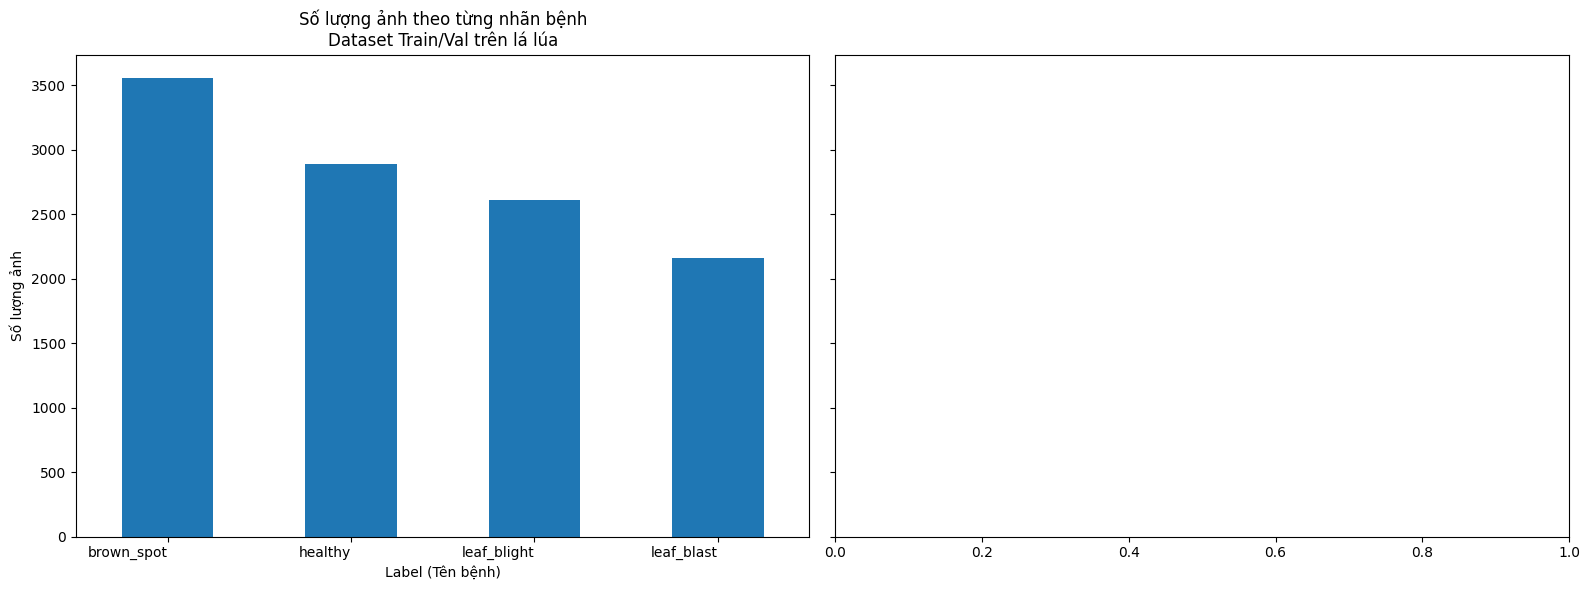

In [67]:
def plot_label_counts(df, name, ax):
    label_counts = df.groupby("label_name")["path"].count().sort_values(ascending=False)
    label_counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Số lượng ảnh theo từng nhãn bệnh\n{name} trên lá lúa")
    ax.set_xlabel("Label (Tên bệnh)")
    ax.set_ylabel("Số lượng ảnh")
    ax.set_xticklabels(label_counts.index, rotation=0, ha="right")
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

plot_label_counts(df, "Dataset Train/Val", axes[0])
# plot_label_counts(df_test, "Dataset Test", axes[1])

plt.tight_layout()
plt.show()

In [68]:
def visualize_by_source(df, num_samples=2, img_size=(128,128), ncols=4):
    sources = sorted(df['dataset_source'].dropna().unique())
    for source in sources:
        source_df = df[df['dataset_source'] == source]
        if len(source_df) == 0:
            continue

        unique_labels = sorted(source_df['label_name'].dropna().unique())
        if len(unique_labels) == 0:
            continue
        samples_all = []
        for label_name in unique_labels:
            label_imgs = source_df[source_df['label_name'] == label_name]['path'].values
            if len(label_imgs) == 0:
                continue
            samples = np.random.choice(label_imgs, 
                                       min(num_samples, len(label_imgs)), 
                                       replace=False)
            for img_path in samples:
                samples_all.append((img_path, label_name))

        if len(samples_all) == 0:
            continue

        nrows = math.ceil(len(samples_all) / ncols)
        plt.figure(figsize=(ncols*3, nrows*3))
        plt.suptitle(f"Samples data prepare train from {source}", fontsize=16)

        for idx, (img_path, label_name) in enumerate(samples_all):
            plt.subplot(nrows, ncols, idx+1)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(img_size)
                plt.imshow(img)
                plt.title(label_name, fontsize=10)
                plt.axis('off')
            except Exception as e:
                plt.text(0.5, 0.5, "Error", ha='center', va='center')
                plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


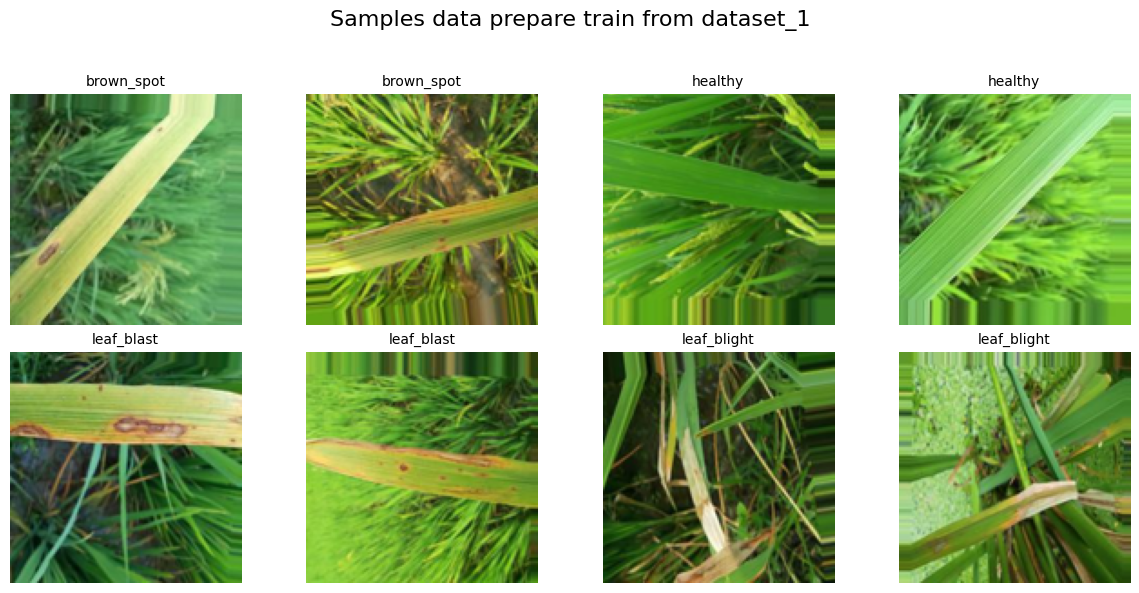

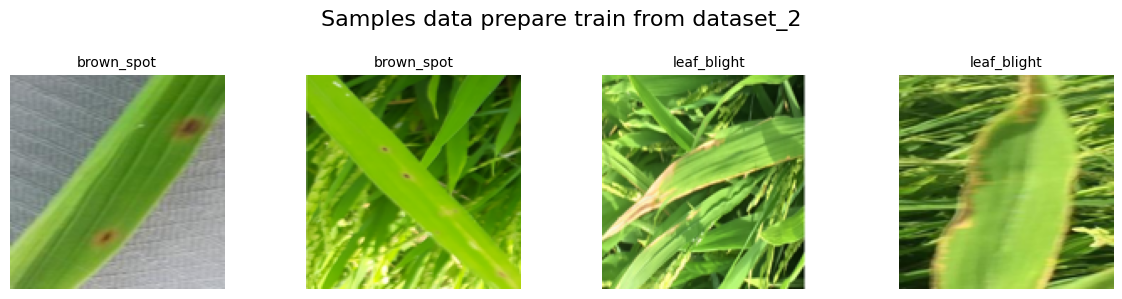

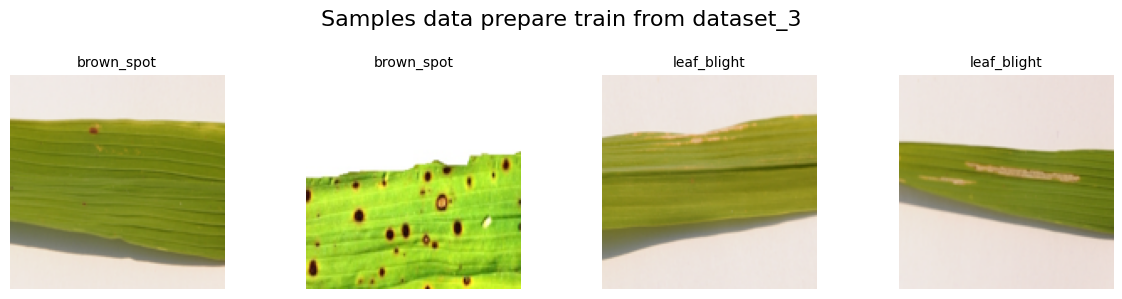

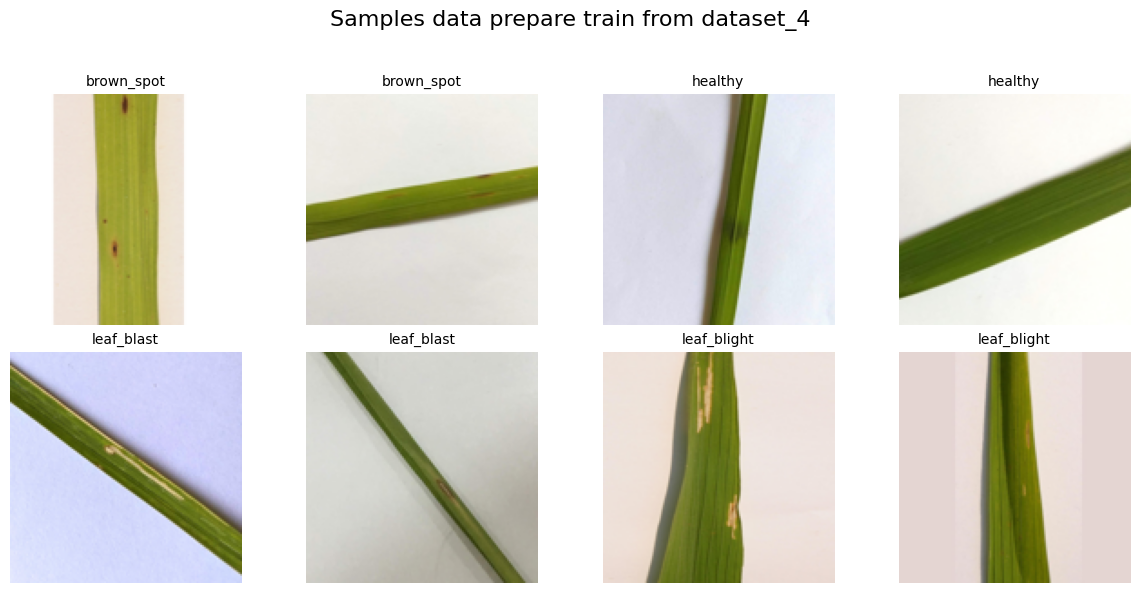

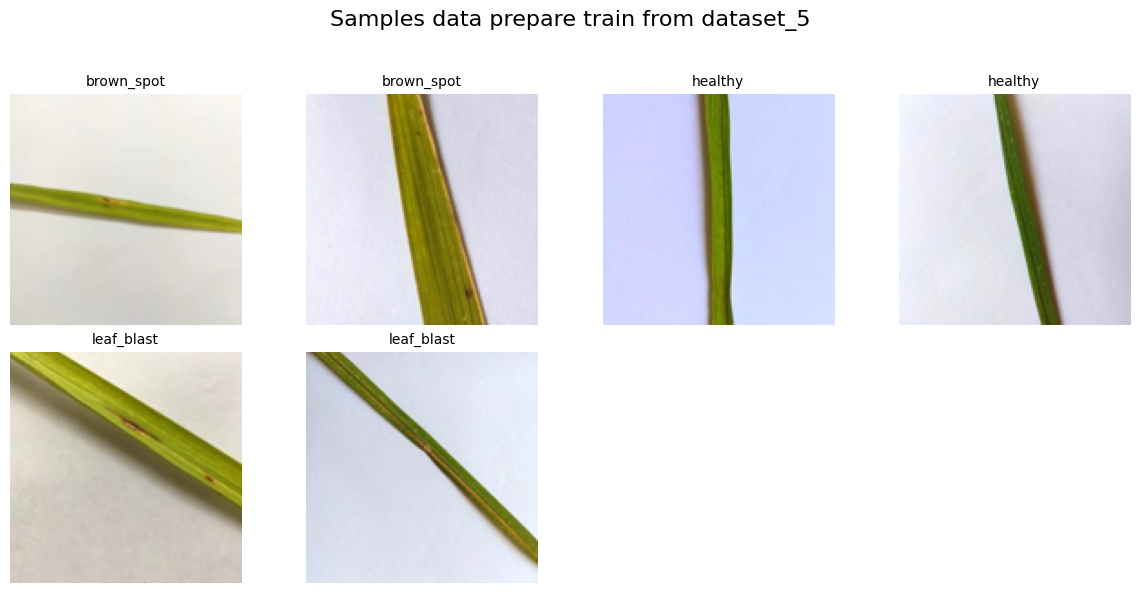

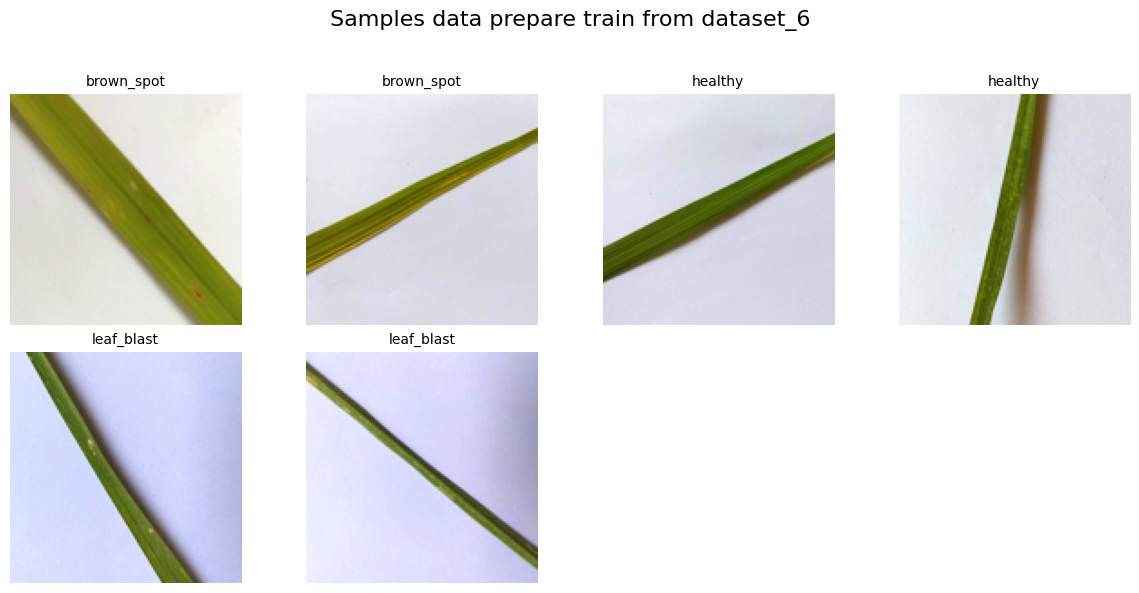

In [69]:
visualize_by_source(df)

In [70]:
visualize_by_source(df_test)

In [71]:
df_stat = df.groupby(["dataset_source", "label_name"]).size().reset_index(name="Count")
pivot_df = df_stat.pivot_table(
    index="label_name", 
    columns="dataset_source", 
    values="Count", 
    aggfunc="sum",
    fill_value=0
)
pivot_df

dataset_source,dataset_1,dataset_2,dataset_3,dataset_4,dataset_5,dataset_6
label_name,,,,,,
brown_spot,646,1600,40,350,523,400
healthy,653,0,0,350,1488,400
leaf_blast,634,0,0,350,779,400
leaf_blight,632,1584,40,350,0,0


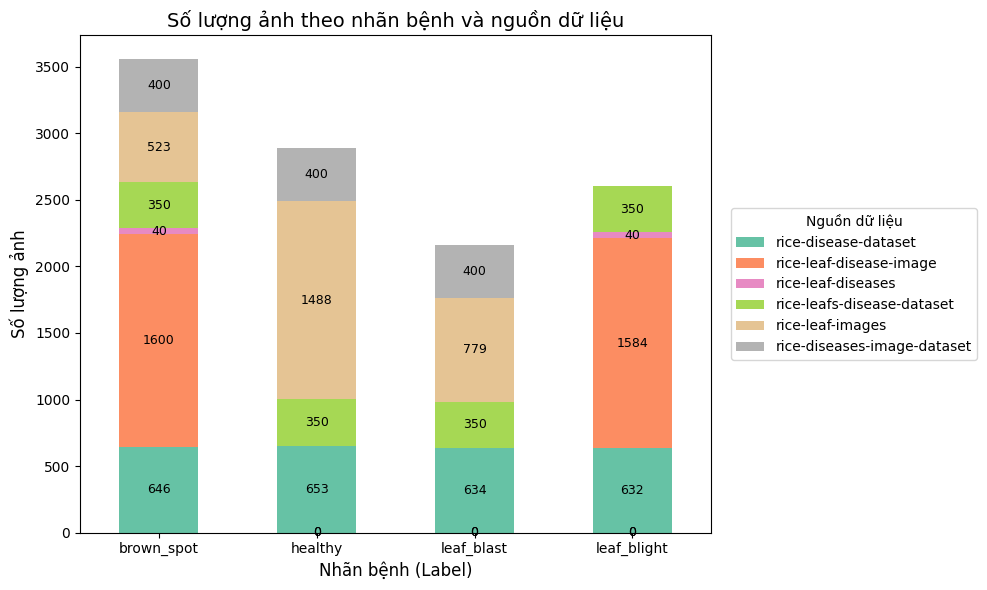

In [72]:
REVERSE_SOURCES = {v: k for k, v in DATASET_SOURCES.items()}
pivot_df_renamed = pivot_df.rename(columns=REVERSE_SOURCES)

ax = pivot_df_renamed.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="Set2"
)

plt.title("Số lượng ảnh theo nhãn bệnh và nguồn dữ liệu", fontsize=14)
plt.xlabel("Nhãn bệnh (Label)", fontsize=12)
plt.ylabel("Số lượng ảnh", fontsize=12)

plt.legend(title="Nguồn dữ liệu", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, label_type="center", fontsize=9)

plt.tight_layout()
plt.show()


### Chia train/val/test

In [73]:
def split_df(df, seed=42, test_size=0.2, val_size=0.2):
    df_trainval, df_test = train_test_split(
        df,
        test_size=test_size,
        random_state=seed,
        stratify=df['label_id'] if 'label_id' in df.columns else None
    )
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=val_size,
        random_state=seed,
        stratify=df_trainval['label_id'] if 'label_id' in df_trainval.columns else None
    )
    train_df = df_train.assign(split="train").reset_index(drop=True)
    val_df   = df_val.assign(split="val").reset_index(drop=True)
    test_df  = df_test.assign(split="test").reset_index(drop=True)

    return pd.concat([train_df, val_df, test_df], ignore_index=True)

def create_filtered_datasets(df, sources=None, test_size=0.2, val_size=0.2, seed=42):
    if sources is not None:
        filtered_df = df[df['dataset_source'].isin(sources)].copy()
    else:
        filtered_df = df.copy()

    if len(filtered_df) == 0:
        print(f"Warning: No data found for sources {sources}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    split_df_result = split_df(filtered_df, seed=seed, test_size=test_size, val_size=val_size)

    train_df = split_df_result[split_df_result["split"] == "train"].reset_index(drop=True)
    val_df   = split_df_result[split_df_result["split"] == "val"].reset_index(drop=True)
    test_df  = split_df_result[split_df_result["split"] == "test"].reset_index(drop=True)

    source_str = "+".join(sources) if sources else "all_sources"
    print(f"Dataset sources: {source_str}")
    print(f"Split sizes: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    return train_df, val_df, test_df

In [74]:
df_split = split_df(df, seed=42)
print(df_split.groupby(["split","label_id","label_name"]).size())

split  label_id  label_name 
test   0         brown_spot      712
       1         leaf_blast      433
       2         leaf_blight     521
       3         healthy         578
train  0         brown_spot     2278
       1         leaf_blast     1384
       2         leaf_blight    1668
       3         healthy        1850
val    0         brown_spot      569
       1         leaf_blast      346
       2         leaf_blight     417
       3         healthy         463
dtype: int64


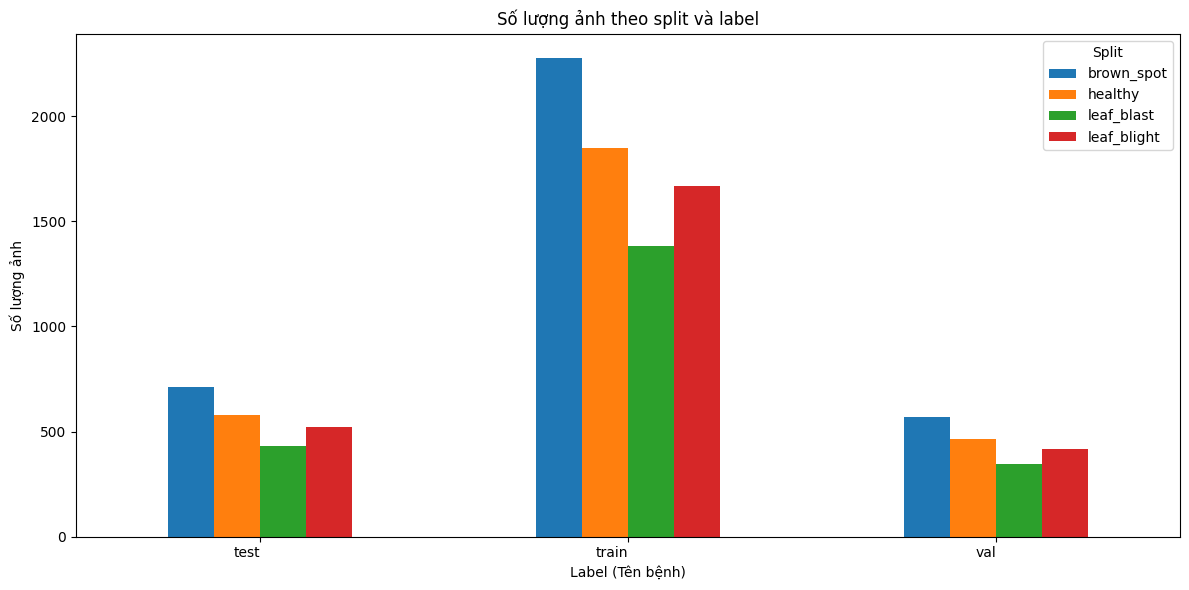

In [75]:
split_counts = df_split.groupby(["split", "label_name"])["path"].count().unstack(fill_value=0)
split_counts.plot(kind="bar", figsize=(12,6))
plt.title("Số lượng ảnh theo split và label")
plt.xlabel("Label (Tên bệnh)")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=0, ha="right")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

### Lưu CSV meta

In [76]:
out_meta = "/kaggle/working/riceleaf_meta.csv"
df_split.to_csv(out_meta, index=False)
print("lưu meta leafrice:", out_meta)

OSError: Cannot save file into a non-existent directory: '/kaggle/working'

### Lưu output ảnh

In [ ]:
DO_COPY = True
OUTROOT = "/kaggle/working/rice_dataset"

if DO_COPY:
    for _, row in df_split.iterrows():
        d = os.path.join(OUTROOT, row["split"], f'{row["label_id"]:02d}_{row["label_name"]}')
        os.makedirs(d, exist_ok=True)
        dst = os.path.join(d, os.path.basename(row["path"]))
        if not os.path.exists(dst):
            shutil.copy2(row["path"], dst)
    print("Đã copy ảnh vào:", OUTROOT)
else:
    print("Dùng trực tiếp path từ df")

## Xử lý dữ liệu

### Đọc dữ liệu từ CSV meta

In [ ]:
meta = pd.read_csv("/kaggle/working/riceleaf_meta.csv")

train_df = meta[meta["split"]=="train"]
val_df   = meta[meta["split"]=="val"]
test_df  = meta[meta["split"]=="test"]
print(train_df.shape, val_df.shape, test_df.shape)

#### CLAHE (Contrast Limited Adaptive Histogram Equalization) để tăng tương phản vùng lá lúa → giúp rõ vết bệnh hơn

| **Khía cạnh**           | **Lợi ích**                                                         | **Bất lợi**                                                                                   |
| ----------------------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **Tương phản**          | Tăng cường chi tiết ở cả vùng sáng và tối, làm rõ vân lá, đốm bệnh. | Có thể làm **nhiễu** trở nên rõ ràng hơn ở vùng nền phẳng.                                    |
| **Ánh sáng môi trường** | Giảm sự khác biệt giữa ảnh chụp ở điều kiện ánh sáng khác nhau.     | Nếu ảnh gốc đã có ánh sáng tốt, CLAHE có thể gây **quá sắc nét**.                             |
| **Tính ổn định**        | Giúp model học feature rõ ràng hơn, đặc biệt với dataset nhỏ.       | Model có thể **overfit vào hình ảnh đã xử lý CLAHE**, kém robust với ảnh thực tế không xử lý. |

In [ ]:
def apply_clahe_pil(pil_img):
    """Áp dụng CLAHE lên ảnh PIL"""
    img = np.array(pil_img.convert("RGB"))  # PIL -> numpy
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # sang không gian LAB
    
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return Image.fromarray(enhanced)


In [ ]:
samples = train_df.sample(5, random_state=42)

plt.figure(figsize=(15, 6))
for i, (path, label) in enumerate(zip(samples['path'], samples['label_name'])):
    img = Image.open(path).convert("RGB")
    img_clahe = apply_clahe_pil(img)

    # Ảnh gốc
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\nOriginal")
    plt.axis('off')

    # Ảnh CLAHE
    plt.subplot(2, 5, i+6)
    plt.imshow(img_clahe)
    plt.title("CLAHE")
    plt.axis('off')

plt.suptitle("So sánh ảnh gốc và sau CLAHE", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def save_clahe_in_batches(df, out_dir, batch_size=200):
    os.makedirs(out_dir, exist_ok=True)
    new_paths = []
    n = len(df)
    for i in tqdm(range(0, n, batch_size), desc=f"Processing {out_dir}"):
        batch = df.iloc[i:i+batch_size]
        for path, label in zip(batch['path'], batch['label_name']):
            img = Image.open(path).convert("RGB")
            img_clahe = apply_clahe_pil(img)

            # thư mục theo nhãn
            label_dir = os.path.join(out_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            # Lưu ảnh CLAHE
            fname = os.path.basename(path)
            save_path = os.path.join(label_dir, fname)
            img_clahe.save(save_path)
            new_paths.append(save_path)
    return new_paths

In [ ]:
train_df = meta[meta["split"]=="train"].copy()
print(train_df.shape, val_df.shape, test_df.shape)
train_df["clahe_path"] = save_clahe_in_batches(train_df, "/kaggle/working/clahe/train", batch_size=200)
train_df["path"] = train_df["clahe_path"]
train_df = train_df.drop(columns=["clahe_path"])

In [ ]:
meta_merged = pd.concat([train_df, val_df, test_df], ignore_index=True)
meta_merged.to_csv("/kaggle/working/riceleaf_meta_merged.csv", index=False)
print(meta_merged.shape)

### Chuẩn hoá ảnh (Resize + Normalize)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3), 
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),  
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### DataLoader

In [ ]:
class RiceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        label = int(row["label_id"])   
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
use_cuda = torch.cuda.is_available()

train_set = RiceDataset(train_df, transform=train_transform)
val_set   = RiceDataset(val_df, transform=val_test_transform)
test_set  = RiceDataset(test_df, transform=val_test_transform)

In [ ]:
test_loader  = DataLoader(test_set, 
                          batch_size=32, 
                          shuffle=False, num_workers=2, 
                          pin_memory=use_cuda)
imgs, labels = next(iter(test_loader))
print("Batch shape:", imgs.shape)
print("Labels:", labels)
print("Min label:", labels.min().item(), "Max label:", labels.max().item())

In [ ]:
train_loader = DataLoader(
    train_set, batch_size=64, 
    shuffle=True,
    num_workers=4,            
    pin_memory=use_cuda,      
    persistent_workers=True,  
    prefetch_factor=2,       
)
val_loader = DataLoader(
    val_set, 
    batch_size=64,
    shuffle=False,
    num_workers=4, 
    pin_memory=use_cuda,
    persistent_workers=True, prefetch_factor=2,
)

In [ ]:
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape)
print("Labels:", labels)
print("Min label:", labels.min().item(), "Max label:", labels.max().item())

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.title(labels[i].item())
    plt.axis("off")
plt.show()

In [ ]:
label_counts = meta.groupby("label_name")["path"].count().sort_values(ascending=False)
print(label_counts)

## Xây dựng mô hình

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = meta["label_id"].nunique()
print(device)

### (1) CNN đơn giản (3 lớp Conv)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1))   # Global Avg Pool
        # self.fc = nn.Linear(128, num_classes)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),               
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### (2) ResNet18 (pretrained)

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

def build_resnet18(num_classes):
    weights = ResNet18_Weights.DEFAULT  # thay cho pretrained=True
    model = resnet18(weights=weights)
    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

### (3) ResNet50 (pretrained)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

def build_resnet50(num_classes):
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

###  (4) EfficientNet-B0 (pretrained)

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def build_efficientnet(num_classes):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    # model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    in_feat = model.classifier[1].in_features 
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.2),  
        nn.Linear(in_feat, num_classes)
    )
    return model

### (5) MobileNetV2 (pretrained)

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

def build_mobilenet(num_classes):
    weights = MobileNet_V2_Weights.DEFAULT
    model = mobilenet_v2(weights=weights)
    # model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    in_feat = model.classifier[1].in_features 
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feat, num_classes)
    )
    return model

### (6) Custom RiceLeafCNN - Specialized Architecture for Rice Disease

In [ ]:
class RiceLeafCNN(nn.Module):
    """Custom architecture specialized for rice leaf disease with focus on efficiency"""
    def __init__(self, num_classes):
        super(RiceLeafCNN, self).__init__()
        
        # Feature extraction path with depth-wise separable convolutions
        self.features = nn.Sequential(
            # Standard first conv
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Depthwise separable blocks for efficiency
            self._depthwise_block(32, 64, stride=1),
            self._depthwise_block(64, 128, stride=2),
            self._depthwise_block(128, 128, stride=1),
            self._depthwise_block(128, 256, stride=2),
            self._depthwise_block(256, 256, stride=1),
            self._depthwise_block(256, 512, stride=2),
            
            # Extra blocks with skip connections for disease texture patterns
            self._residual_block(512, 512),
            self._residual_block(512, 512),
        )
        
        # Disease-specific pattern enhancement with dilated convolutions
        self.pattern_enhancer = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2, groups=512, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 1, bias=False),  # Pointwise
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _depthwise_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            # Depthwise
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            # Pointwise
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def _residual_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, groups=out_channels, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.features(x)
        x = self.pattern_enhancer(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

| Mô hình             | Lõi kiến trúc                                                               | Đặc trưng chính                    | Điểm mạnh                                          | Hạn chế                                                 | Khi nên dùng                                                  |
| ------------------- | --------------------------------------------------------------------------- | ---------------------------------- | -------------------------------------------------- | ------------------------------------------------------- | ------------------------------------------------------------- |
| **SimpleCNN**       | 3× (Conv+ReLU+MaxPool) → GAP → FC                                           | Cực đơn giản, dễ debug             | Nhanh, ít tham số, baseline tốt                    | Biểu đạt hạn chế trên mẫu phức tạp                      | Kiểm thử pipeline, dataset rất nhỏ                            |
| **RiceLeafCNN**     | Depthwise-separable + (khối “residual” tùy chỉnh) + dilated depthwise + GAP | Tối ưu họa tiết lá, nhẹ            | Hiệu quả FLOPs/tham số tốt; nhấn mạnh pattern bệnh | “Residual” trong code chưa có skip; cần tinh chỉnh thêm | Bài toán lá/bệnh; cần mô hình gọn nhưng giàu đặc trưng cục bộ |
| **ResNet-18**       | Residual basic blocks (2×3×3)                                               | Skip connection giúp train ổn định | Triển khai dễ, ổn định, nhanh hơn ResNet-50        | Chính xác kém hơn mạng sâu hơn                          | Baseline chắc, inference nhanh                                |
| **ResNet-50**       | Residual **bottleneck** (1×1–3×3–1×1)                                       | Sâu hơn, mạnh hơn R18              | Chính xác tốt, phổ biến                            | Nặng hơn MobileNet/EffNet-B0                            | Khi cần thêm accuracy nhưng vẫn muốn kiến trúc “chuẩn”        |
| **EfficientNet-B0** | **MBConv + SE** + compound scaling                                          | Rất hiệu quả params/FLOPs          | Accuracy cao với chi phí thấp                      | Cấu trúc phức tạp hơn; nhạy preprocessing               | Muốn tối ưu **accuracy/compute**                              |
| **MobileNetV2**     | **Inverted residual + linear bottleneck**                                   | Cực nhẹ, depthwise separable       | Rất nhanh/nhẹ (edge)                               | Accuracy < EffNet-B0/ResNet-50                          | Thiết bị giới hạn, realtime                                   |


## Train

### Kiểm tra máy tính

In [ ]:
# Chọn thiết bị: xác định dùng CPU hay GPU (CUDA).
# Tạo AMP context: bật autocast nếu có CUDA, ngược lại dùng nullcontext().
# Tạo GradScaler: chọn API mới/cũ và bật tắt theo tình trạng CUDA.

def setup_amp():
    try:
        from torch.amp import GradScaler, autocast
        NEW_AMP = True
    except Exception:
        from torch.cuda.amp import GradScaler, autocast
        NEW_AMP = False
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if not use_cuda:
        amp_ctx = nullcontext()
    else:
        amp_ctx = autocast(device_type="cuda", enabled=True) if NEW_AMP else autocast(enabled=True)
    if NEW_AMP:
        scaler = GradScaler(device="cuda" if use_cuda else "cpu", enabled=use_cuda)
    else:
        scaler = GradScaler(enabled=use_cuda)
    return device, amp_ctx, scaler

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, mode="min", min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, current):
        if self.best is None:
            self.best = current
            return False

        improvement = (current < self.best - self.min_delta) if self.mode == "min" else (current > self.best + self.min_delta)

        if improvement:
            self.best = current
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

In [ ]:
torch.backends.cudnn.benchmark = bool(torch.cuda.is_available())
def prepare_model(model, lr, monitor):
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min" if monitor=="val_loss" else "max", factor=0.5, patience=2)
    return model, scheduler, optimizer, criterion

In [ ]:
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-4, device=None, ckpt_path="/kaggle/working/best.pth", es_patience=5, monitor="val_loss"):
    dev, amp_ctx, scaler = setup_amp()
    if device is None:   
        device = dev

    model, scheduler, optimizer, criterion = prepare_model(model, lr, monitor)
    es = EarlyStopping(patience=es_patience, mode=("min" if monitor=="val_loss" else "max"), min_delta=0.0)

    best_metric = float("inf") if monitor=="val_loss" else -float("inf")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        # TRAIN 
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train E{epoch}/{epochs}")

        for imgs, labels in pbar:
            imgs   = imgs.to(device, non_blocking=True)
            labels = labels.long().to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with amp_ctx:   
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += float(loss.item()) * imgs.size(0)
            preds = outputs.argmax(1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)
            pbar.set_postfix(loss=float(loss.item()))

        train_loss = running_loss / max(1, running_total)
        train_acc  = running_correct / max(1, running_total)
        
        # VALID 
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Valid E{epoch}/{epochs}"):
                imgs   = imgs.to(device, non_blocking=True)
                labels = labels.long().to(device, non_blocking=True)
                with amp_ctx:  
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                val_loss_sum += float(loss.item()) * imgs.size(0)
                val_correct  += (outputs.argmax(1) == labels).sum().item()
                val_total    += labels.size(0)

        val_loss = val_loss_sum / max(1, val_total)
        val_acc  = val_correct / max(1, val_total)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch}/{epochs} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

        monitored_value = val_loss if monitor == "val_loss" else val_acc
        scheduler.step(monitored_value)

        is_better = (monitored_value < best_metric) if monitor=="val_loss" else (monitored_value > best_metric)
        if is_better:
            best_metric = monitored_value
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved BEST to {ckpt_path} (best {monitor}: {best_metric:.4f})")
        if es.step(monitored_value):
            print(f"Early stopping at epoch {epoch} (no improvement on {monitor})")
            break

    print(f"Best {monitor}: {best_metric:.4f}")
    return history, ckpt_path

In [ ]:
@torch.no_grad()
def evaluate_on_loader(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.long().to(device, non_blocking=True)
        logits = model(imgs)
        preds  = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    y_pred  = np.concatenate(all_preds)
    y_true  = np.concatenate(all_labels)
    acc     = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"test_acc": acc, "precision": p, "recall": r, "f1": f1, "confusion_matrix": confusion_matrix(y_true, y_pred)}

def count_params_m(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

@torch.no_grad()
def measure_latency_ms(model, device, input_size=(1,3,224,224), warmup=10, runs=30):
    model.eval()
    x = torch.randn(*input_size, device=device)
    # warm-up
    for _ in range(warmup):
        _ = model(x)
    # measure
    torch.cuda.synchronize() if device.type == "cuda" else None
    t0 = time.time()
    for _ in range(runs):
        _ = model(x)
    torch.cuda.synchronize() if device.type == "cuda" else None
    dt = (time.time() - t0) / runs
    return dt * 1000.0  


In [ ]:
def plot_history(history, title="Training Curve", show=True, save_path=None, monitor="val_loss"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))

    # Tìm best point theo monitor
    if monitor == "val_loss":
        best_epoch = int(np.argmin(history["val_loss"])) + 1
        best_value = min(history["val_loss"])
        label_text = f"Best Val Loss={best_value:.4f} (Epoch {best_epoch})"
    else:  # val_acc
        best_epoch = int(np.argmax(history["val_acc"])) + 1
        best_value = max(history["val_acc"])
        label_text = f"Best Val Acc={best_value:.4f} (Epoch {best_epoch})"

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.scatter(best_epoch, history["val_acc"][best_epoch-1], color="red", marker="o", s=80, label="Best Point")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.scatter(best_epoch, history["val_loss"][best_epoch-1], color="red", marker="o", s=80, label="Best Point")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss\n{label_text}")
    plt.legend()

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    if show:
        plt.show()

In [ ]:
def comprehensive_evaluation(models_dict, dataset_combinations, device, epochs=10):
    results = []
    all_histories = {}
    
    for sources in dataset_combinations:
        source_name = "+".join(sources) if sources else "all_sources"
        print(f"\n===== EVALUATING ON {source_name} =====")
        
        # Create datasets for this combination
        train_df_filtered, val_df_filtered, test_df_filtered = create_filtered_datasets(meta, sources=sources)
        
        if len(train_df_filtered) == 0:
            print(f"Skipping {source_name} - no data found")
            continue
        
        # Create dataloaders
        train_set = RiceDataset(train_df_filtered, transform=train_transform)
        val_set = RiceDataset(val_df_filtered, transform=val_test_transform)
        test_set = RiceDataset(test_df_filtered, transform=val_test_transform)
        
        train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
        test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
        
        for model_name, model_constructor in models_dict.items():
            print(f"\nTraining {model_name} on {source_name}")
            
            # Initialize model
            model = model_constructor().to(device)
            
            # Train model
            ckpt_path = f"/kaggle/working/{model_name}_{source_name}_best.pth"
            history, _ = train_model(
                model, train_loader, val_loader,
                epochs=epochs, lr=1e-4, device=device,
                ckpt_path=ckpt_path, 
                es_patience=5, monitor="val_loss"
            )
            
            all_histories[f"{model_name}_{source_name}"] = history
            plot_history(history, title=f"{model_name} on {source_name}", save_path=f"/kaggle/working/modeltraining/{model_name}_{source_name}_curve.png", monitor="val_acc")
            # Load best weights and evaluate
            model.load_state_dict(torch.load(ckpt_path, map_location=device))
            test_metrics = evaluate_on_loader(model, test_loader, device)
            
            # Model metrics
            params_m = count_params_m(model)
            latency_ms = measure_latency_ms(model, device)
            fps = 1000 / latency_ms
            
            # Save results
            results.append({
                "Model": model_name,
                "Dataset": source_name,
                "Test Acc": test_metrics["test_acc"],
                "Precision": test_metrics["precision"],
                "Recall": test_metrics["recall"],
                "F1": test_metrics["f1"],
                "Params (M)": params_m,
                "Latency (ms)": latency_ms,
                "FPS": fps,
                "Checkpoint": ckpt_path
            })
            
            # Clean up
            del model
            torch.cuda.empty_cache()
            gc.collect()
    
    return pd.DataFrame(results), all_histories

In [ ]:
source_combinations = [
    ["dataset_1"],  
    ["dataset_1", "dataset_4"],
    None,  
]

models_list = {
    "SimpleCNN":       lambda: SimpleCNN(num_classes),
    "RiceLeafCNN":     lambda: RiceLeafCNN(num_classes), 
    "ResNet18":        lambda: build_resnet18(num_classes),
    "ResNet50":        lambda: build_resnet50(num_classes),
    "EfficientNetB0":  lambda: build_efficientnet(num_classes),
    "MobileNetV2":     lambda: build_mobilenet(num_classes),
}

results_df, histories = comprehensive_evaluation(models_list, source_combinations, device, epochs=20)

print("\n" + "="*50)
print("COMPREHENSIVE RESULTS") 
print("="*50)
print(results_df.to_string(index=False))
results_df.to_csv("/kaggle/working/comprehensive_results.csv", index=False)

## So sánh model

In [ ]:
# SO SÁNH TEST ACCURACY GIỮA CÁC MODEL THEO TỪNG BỘ DATASET
def plot_model_dataset_accuracy_comparison(results_df):
    if len(results_df) == 0:
        print("Không có dữ liệu để hiển thị")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('So sánh Test Accuracy: Models vs Datasets', fontsize=16, fontweight='bold')
    
    # 1. Grouped Bar Chart
    ax1 = axes[0, 0]
    pivot_acc = results_df.pivot(index='Model', columns='Dataset', values='Test Acc')
    
    # Plot grouped bars
    pivot_acc.plot(kind='bar', ax=ax1, width=0.8, colormap='tab10')
    ax1.set_title('Test Accuracy by Model and Dataset', fontsize=14)
    ax1.set_ylabel('Test Accuracy', fontsize=12)
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylim(0, 1.0)
    ax1.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', fontsize=9, rotation=90)
    
    # 2. Heatmap
    ax2 = axes[0, 1]
    sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='RdYlGn', 
                ax=ax2, cbar_kws={'label': 'Test Accuracy'})
    ax2.set_title('Accuracy Heatmap', fontsize=14)
    ax2.set_xlabel('Dataset', fontsize=12)
    ax2.set_ylabel('Model', fontsize=12)
    
    # 3. Line Plot - Xu hướng accuracy qua các dataset
    ax3 = axes[1, 0]
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        ax3.plot(model_data['Dataset'], model_data['Test Acc'], 
                marker='o', linewidth=2, markersize=8, label=model)
    
    ax3.set_title('Accuracy Trends Across Datasets', fontsize=14)
    ax3.set_ylabel('Test Accuracy', fontsize=12)
    ax3.set_xlabel('Dataset', fontsize=12)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Stacked Bar Chart - Contribution comparison
    ax4 = axes[1, 1]
    pivot_acc_T = pivot_acc.T  # Transpose for stacked bars
    pivot_acc_T.plot(kind='bar', stacked=True, ax=ax4, colormap='Set3')
    ax4.set_title('Stacked Accuracy by Dataset', fontsize=14)
    ax4.set_ylabel('Cumulative Test Accuracy', fontsize=12)
    ax4.set_xlabel('Dataset', fontsize=12)
    ax4.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/model_dataset_accuracy_comparison.png", 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("THỐNG KÊ CHI TIẾT ACCURACY THEO MODEL VÀ DATASET")
    print("="*60)
    
    # Best performer for each dataset
    print("\n MODEL TỐT NHẤT CHO TỪNG DATASET:")
    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[results_df['Dataset'] == dataset]
        best_model = dataset_data.loc[dataset_data['Test Acc'].idxmax()]
        print(f"   {dataset}: {best_model['Model']} ({best_model['Test Acc']:.4f})")
    
    # Average performance by model
    print("\n ACCURACY TRUNG BÌNH CỦA TỪNG MODEL:")
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        avg_acc = model_data['Test Acc'].mean()
        std_acc = model_data['Test Acc'].std()
        print(f"   {model}: {avg_acc:.4f} ± {std_acc:.4f}")
    
    # Dataset difficulty ranking
    print("\n XẾP HẠNG ĐỘ KHÓ CỦA CÁC DATASET (theo accuracy trung bình):")
    dataset_avg = results_df.groupby('Dataset')['Test Acc'].mean().sort_values(ascending=False)
    for i, (dataset, avg_acc) in enumerate(dataset_avg.items(), 1):
        difficulty = "Dễ" if avg_acc > 0.9 else "Trung bình" if avg_acc > 0.8 else "Khó"
        print(f"   {i}. {dataset}: {avg_acc:.4f} ({difficulty})")

# Run the comparison
if 'results_df' in locals() and len(results_df) > 0:
    plot_model_dataset_accuracy_comparison(results_df)
elif 'df_results' in locals() and len(df_results) > 0:
    # If using the old variable name
    plot_model_dataset_accuracy_comparison(df_results)
else:
    # Create sample data for demonstration
    print("Không tìm thấy results_df. Tạo dữ liệu mẫu để demo...")
    sample_data = {
        'Model': ['SimpleCNN', 'RiceLeafCNN', 'ResNet18', 'MobileNetV2'] * 3,
        'Dataset': ['all_sources'] * 4 + ['dataset_1'] * 4 + ['dataset_1+dataset_2'] * 4,
        'Test Acc': [0.85, 0.89, 0.92, 0.87, 0.83, 0.88, 0.91, 0.86, 0.86, 0.90, 0.93, 0.88]
    }
    sample_df = pd.DataFrame(sample_data)
    plot_model_dataset_accuracy_comparison(sample_df)


In [ ]:
def plot_model_comparison_by_dataset(results_df):
    """Plot performance comparison of models across different datasets"""
    plt.figure(figsize=(14, 10))
    
    # Accuracy comparison
    plt.subplot(2, 2, 1)
    pivot_acc = results_df.pivot(index='Model', columns='Dataset', values='Test Acc')
    pivot_acc.plot(kind='bar', ax=plt.gca())
    plt.title('Accuracy by Model and Dataset')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Speed (FPS) comparison  
    plt.subplot(2, 2, 2)
    pivot_fps = results_df.pivot(index='Model', columns='Dataset', values='FPS')
    pivot_fps.plot(kind='bar', ax=plt.gca())
    plt.title('Speed (FPS) by Model and Dataset')
    plt.ylabel('FPS')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.subplot(2, 2, 3)
    for dataset in results_df['Dataset'].unique():
        df_subset = results_df[results_df['Dataset'] == dataset]
        plt.scatter(df_subset['Params (M)'], df_subset['Test Acc'], 
                   label=dataset, s=100, alpha=0.7)
        for _, row in df_subset.iterrows():
            plt.annotate(row['Model'], 
                        (row['Params (M)'], row['Test Acc']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('Model Size (M parameters)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Size vs Accuracy')
    plt.legend(title='Dataset')
    plt.subplot(2, 2, 4)
    for dataset in results_df['Dataset'].unique():
        df_subset = results_df[results_df['Dataset'] == dataset]
        plt.scatter(df_subset['FPS'], df_subset['Test Acc'], 
                   label=dataset, s=100, alpha=0.7)
        for _, row in df_subset.iterrows():
            plt.annotate(row['Model'], 
                        (row['FPS'], row['Test Acc']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('Speed (FPS)')
    plt.ylabel('Test Accuracy')
    plt.title('Speed vs Accuracy')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.savefig('/kaggle/working/model_dataset_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

if len(results_df) > 0:
    plot_model_comparison_by_dataset(results_df)

In [ ]:
def analyze_training_stability(model_histories):
    """Analyze training curves for stability and convergence"""
    if not model_histories:
        print("No training histories available")
        return
        
    plt.figure(figsize=(15, 10))
    
    # Loss stability 
    plt.subplot(2, 2, 1)
    for model_name, history in model_histories.items():
        if 'train_loss' in history:
            plt.plot(history['train_loss'], label=f"{model_name}")
    plt.title('Training Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Validation loss stability
    plt.subplot(2, 2, 2)
    for model_name, history in model_histories.items():
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label=f"{model_name}")
    plt.title('Validation Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Accuracy progress
    plt.subplot(2, 2, 3)
    for model_name, history in model_histories.items():
        if 'train_acc' in history:
            plt.plot(history['train_acc'], label=f"{model_name}")
    plt.title('Training Accuracy Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Validation accuracy progress
    plt.subplot(2, 2, 4)
    for model_name, history in model_histories.items():
        if 'val_acc' in history:
            plt.plot(history['val_acc'], label=f"{model_name}")
    plt.title('Validation Accuracy Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_stability_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Overfitting analysis
    print("\nTraining Stability Analysis:")
    print("="*50)
    for model_name, history in model_histories.items():
        if 'train_loss' in history and 'val_loss' in history:
            train_loss = history['train_loss']
            val_loss = history['val_loss']
            
            if len(train_loss) > 0 and len(val_loss) > 0:
                # Calculate generalization gap
                min_len = min(len(train_loss), len(val_loss))
                gen_gaps = [val_loss[i] - train_loss[i] for i in range(min_len)]
                
                print(f"\n{model_name}:")
                print(f"  Final train/val loss gap: {gen_gaps[-1]:.4f}")
                print(f"  Max train/val loss gap: {max(gen_gaps):.4f}")
                print(f"  Epochs until min val loss: {val_loss.index(min(val_loss))+1}")
                
                # Flag potential issues
                if gen_gaps[-1] > 0.1:
                    print("  Potential overfitting detected")
                if min(val_loss) > 0.5:
                    print("  High validation loss - model may be underfitting")

if 'histories' in locals() and histories:
    analyze_training_stability(histories)

## Đánh giá model

In [ ]:
df = pd.read_csv("/kaggle/working/comprehensive_results.csv")

best_row = df.sort_values("Test Acc", ascending=False).iloc[0]
best_ckpt = best_row["Checkpoint"]
best_model_name = best_row["Model"]
best_acc = best_row["Test Acc"]
print(f"Best model: {best_model_name} ({best_ckpt}), acc={best_acc:.4f}")

In [ ]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = np.mean(np.array(all_labels) == np.array(all_preds))
    print(f"Test Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
class_names = train_df["label_name"].unique().tolist()

def select_best_row(results_df: pd.DataFrame, key="F1", dataset: str | None = None):
    df = results_df if dataset is None else results_df[results_df["Dataset"] == dataset]
    if len(df) == 0:
        raise ValueError(f"Không tìm thấy run nào cho dataset={dataset}")
    return df.loc[df[key].idxmax()]   # Series

def load_model_from_row(best_row, models_dict, device):
    model_name = best_row["Model"]
    ckpt_path  = best_row["Checkpoint"]
    if model_name not in models_dict:
        raise KeyError(f"'{model_name}' không có trong models_dict")
    model = models_dict[model_name]().to(device)
    state = torch.load(ckpt_path, map_location=device)
    # hỗ trợ cả state_dict thuần và checkpoint dict
    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        model.load_state_dict(state)
    model.eval()
    return model, ckpt_path

def auto_load_best_model(results_csv, models_dict, device, key="F1", dataset=None):
    results_df = pd.read_csv(results_csv)
    best_row = select_best_row(results_df, key=key, dataset=dataset)
    print(f"Best by {key}: {best_row['Model']} @ {best_row['Dataset']} ({best_row[key]:.4f})")
    model, ckpt = load_model_from_row(best_row, models_dict, device)
    return model, best_row

# ===== DÙNG =====
results_csv = "/kaggle/working/comprehensive_results.csv"
model_best, info = auto_load_best_model(results_csv, models_list, device, key="F1", dataset=None)

# Nếu bạn đã có sẵn test_loader + class_names:
evaluate_model(model_best, test_loader, class_names)

## Dự đoán

In [ ]:
def infer_arch_from_path(ckpt_path: str) -> str:
    """Đoán tên kiến trúc từ tên file checkpoint."""
    base = os.path.basename(ckpt_path).lower()
    mapping = {
        "resnet18": "ResNet18",
        "resnet50": "ResNet50",
        "mobilenetv2": "MobileNetV2",
        "efficientnetb0": "EfficientNetB0",
        "riceleafcnn": "RiceLeafCNN",
        "simplecnn": "SimpleCNN",
    }
    for k, v in mapping.items():
        if k in base:
            return v
    raise ValueError(f"Không suy luận được kiến trúc từ tên file: {base}")

def load_saved_model_by_ckpt(ckpt_path, models_dict, device, strict_head="auto"):
    """
    Khởi tạo đúng kiến trúc theo ckpt_path rồi load state_dict.
    - models_dict: {"ResNet18": lambda: build_resnet18(num_classes), ...}
    - strict_head="auto": thử strict=True; nếu chỉ lỗi ở head thì fallback strict=False.
    """
    arch = infer_arch_from_path(ckpt_path)
    if arch not in models_dict:
        raise KeyError(f"'{arch}' không có trong models_dict")

    model = models_dict[arch]().to(device)
    state = torch.load(ckpt_path, map_location=device)
    if isinstance(state, dict) and "model_state_dict" in state:
        state = state["model_state_dict"]

    try:
        model.load_state_dict(state, strict=True)
    except RuntimeError as e:
        if strict_head == "auto":
            print(f"strict=True lỗi ({e.__class__.__name__}): thử strict=False (có thể sai head).")
            model.load_state_dict(state, strict=False)
        else:
            raise
    model.eval()
    return model, arch

def ensure_save_dir_from_path(path: str) -> str:
    """Trả về thư mục hợp lệ để lưu file theo một 'path' (file hoặc folder)."""
    if os.path.isdir(path):
        save_dir = path
    else:
        save_dir = os.path.dirname(path) or "."
    os.makedirs(save_dir, exist_ok=True)
    return save_dir


In [ ]:

def demo_prediction_with_saved_model(checkpoint_path="../output", dataset_path="data", num_samples=6):
    print("DEMO PREDICTION VỚI MODEL ĐÃ SAVE")
    print("="*60)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_images = []
    class_names = None
    if not isinstance(dataset_path, pd.DataFrame):
        raise TypeError("`dataset_path` phải là str/path hoặc pandas.DataFrame")
    df_in = dataset_path.copy()
    if 'path' not in df_in.columns:
        raise ValueError("DataFrame phải có cột 'path'.")
    label_col = None
    if 'label_name' in df_in.columns:
        label_col = 'label_name'
    else:
        for c in ['label', 'class', 'target', 'y', 'category']:
            if c in df_in.columns:
                label_col = c; break
    has_label_id = 'label_id' in df_in.columns
    if label_col is None and not has_label_id:
        raise ValueError("Thiếu nhãn: cần 'label_name' hoặc 1 trong ['label','class','target','y','category'] hoặc 'label_id'.")

    if has_label_id and 'label_name' in df_in.columns:
        id_name = df_in[['label_id','label_name']].drop_duplicates().sort_values('label_id')
        class_names = id_name['label_name'].astype(str).tolist()
        id_to_idx = {int(i): idx for idx, i in enumerate(id_name['label_id'].tolist())}
        for _, row in df_in.iterrows():
            img_path = str(row['path'])
            if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg','.jpeg','.png')):
                lid = int(row['label_id'])
                if lid in id_to_idx:
                    all_images.append({
                        'path': img_path,
                        'true_label': str(row['label_name']),
                        'true_label_idx': id_to_idx[lid],
                    })
    elif has_label_id and label_col is None:
        uniq_ids = sorted(set(int(x) for x in df_in['label_id'].tolist()))
        class_names = [str(i) for i in uniq_ids]
        id_to_idx = {i: idx for idx, i in enumerate(uniq_ids)}
        for _, row in df_in.iterrows():
            img_path = str(row['path'])
            if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg','.jpeg','.png')):
                lid = int(row['label_id'])
                if lid in id_to_idx:
                    all_images.append({
                        'path': img_path,
                        'true_label': str(lid),
                        'true_label_idx': id_to_idx[lid],
                    })
    else:
        labels_series = df_in[label_col].astype(str)
        class_names = sorted(labels_series.unique().tolist())
        class_to_idx = {c:i for i,c in enumerate(class_names)}
        for _, row in df_in.iterrows():
            img_path = str(row['path'])
            if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg','.jpeg','.png')):
                name = str(row[label_col])
                all_images.append({
                    'path': img_path,
                    'true_label': name,
                    'true_label_idx': class_to_idx[name],
                })

    if len(all_images) == 0:
        raise RuntimeError("❌ Không tìm thấy ảnh nào để test!")
    print(f"Tìm thấy {len(all_images)} ảnh. Số lớp: {len(class_names)} -> {class_names}")
    models_dict = {
        "SimpleCNN":      lambda: SimpleCNN(len(class_names)),
        "RiceLeafCNN":    lambda: RiceLeafCNN(len(class_names)),
        "ResNet18":       lambda: build_resnet18(len(class_names)),
        "ResNet50":       lambda: build_resnet50(len(class_names)),
        "EfficientNetB0": lambda: build_efficientnet(len(class_names)),
        "MobileNetV2":    lambda: build_mobilenet(len(class_names)),
    }
    model, model_name = load_saved_model_by_ckpt(
        ckpt_path=checkpoint_path,
        models_dict=models_dict,
        device=device,
        strict_head="auto",
    )

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    random_images = random.sample(all_images, min(num_samples, len(all_images)))
    rows = 2 if len(random_images) > 3 else 1
    cols = min(3, len(random_images))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if hasattr(axes, "ravel"):
        axes = axes.ravel()
    else:
        axes = [axes]

    total_time = 0.0
    correct_predictions = 0

    for idx, img_info in enumerate(random_images):
        img_path = img_info['path']
        image = Image.open(img_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        start_time = time.time()
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        end_time = time.time()

        inference_time = end_time - start_time
        total_time += inference_time

        predicted_idx = predicted.item()
        predicted_class = class_names[predicted_idx]
        confidence_score = float(confidence.item())
        true_class = img_info['true_label']
        is_correct = (str(predicted_class) == str(true_class))
        if is_correct:
            correct_predictions += 1

        ax = axes[idx]
        ax.imshow(image)
        ax.set_title(
            f"True: {true_class}\nPred: {predicted_class}\n"
            f"Conf: {confidence_score:.3f}\n"
            f"Time: {inference_time*1000:.1f}ms",
            fontsize=10
        )
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('green' if is_correct else 'red')
            spine.set_linewidth(3)

        status = "đúng" if is_correct else "sai"
        print(f"{os.path.basename(img_path)} | True: {true_class} | Pred: {predicted_class} "
              f"| {confidence_score:.4f} | {inference_time*1000:.2f}ms | {status}")

    # Ẩn subplot thừa
    for j in range(len(random_images), len(axes)):
        axes[j].axis('off')
    plt.suptitle(f'Random Prediction Demo - {model_name}', fontsize=16)
    plt.tight_layout()
    # Lưu ảnh DEMO vào đúng thư mục 
    save_dir = ensure_save_dir_from_path(checkpoint_path)
    out_img = os.path.join(save_dir, "demo_predictions.png")
    plt.savefig(out_img, dpi=150, bbox_inches='tight')
    plt.show()
    #  Summary 
    accuracy = correct_predictions / len(random_images)
    avg_time = total_time / len(random_images)
    fps = len(random_images) / total_time if total_time > 0 else float('inf')

    print("DEMO SUMMARY:")
    print("="*40)
    print(f"Model: {model_name}")
    print(f"Accuracy: {correct_predictions}/{len(random_images)} ({accuracy*100:.1f}%)")
    print(f"Avg Time: {avg_time*1000:.2f}ms/image")
    print(f"Speed: {fps:.1f} FPS")
    print(f"Saved preview: {out_img}")

In [ ]:
demo_prediction_with_saved_model(
    checkpoint_path=best_ckpt,   
    dataset_path=df_test,
    num_samples=6
)